In [1]:
from imageio import imread
import matplotlib.pyplot as plt
import numpy as np
import random
import math
import time

%matplotlib inline

TODO

2. Add colour transformations
4. Recompute theta in resize function
5. Test batch time

In [2]:
import tools._init_paths
import dataset
import torch
import torchvision.transforms as transforms
from dataset import custom_transforms

from utils.data_manipulation import add_dist_along_vector, add_dict_perpendicular_vector, rotate_point_by_angle
from utils.data_manipulation import get_object_aligned_box, plot_image_coordinates

from core.evaluate import normalize_theta

In [3]:
from config import cfg
cfg.merge_from_file('experiments/1_resnet_simple.yaml')

In [4]:
cfg.DATASET.NAME = 'seadragon'#'mantaray' #'hammerhead'

# Custom transforms unit testing

In [5]:
train_dataset = eval('dataset.'+cfg.DATASET.CLASS)(cfg, True, None)
valid_dataset = eval('dataset.'+cfg.DATASET.CLASS)(cfg, False, None)

loading annotations into memory...
Done (t=0.12s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [6]:
from dataset.custom_transforms import RandomHorizontalFlip, RandomVerticalFlip, RandomRotate, RandomScale, Resize
from dataset.custom_transforms import CropObjectAlignedArea, ResizeKeepRatio

In [7]:
tf_test = { 'Horizontal flip': RandomHorizontalFlip(p=1.), 
            'Vertical flip': RandomVerticalFlip(p=1.),
            'RandomRotations': RandomRotate(degrees=90),
            'RandomScale': RandomScale(scale=(0.8, 1.2)),
            'Resize': Resize(256),
            'ResizeKeepRatio': ResizeKeepRatio(256),
            'CropObjectArea': CropObjectAlignedArea(0., 1.),
}

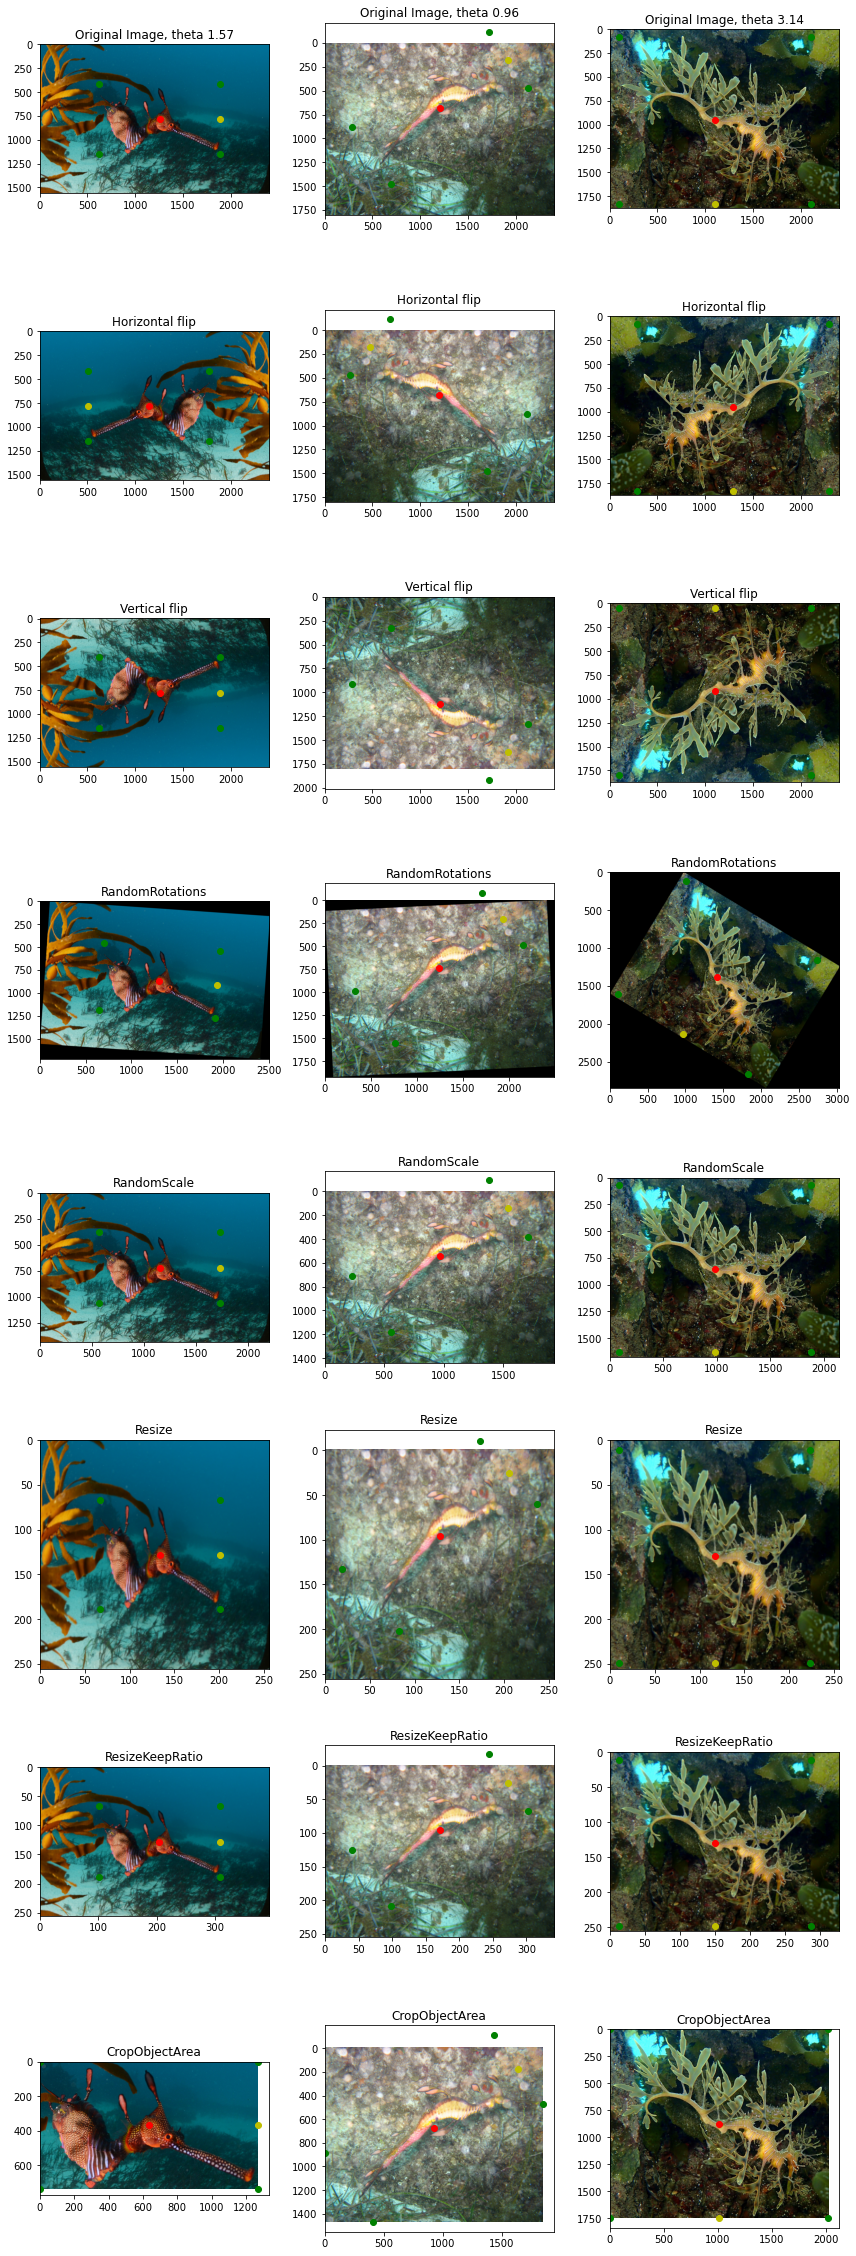

In [8]:
fig, ax = plt.subplots(nrows=len(tf_test)+1, ncols=3, figsize=(3*4, (len(tf_test)+1)*4))
for c in range(3):
    image, xc, yc, xt, yt, w, theta = train_dataset[random.randint(0, len(train_dataset)-1)]
    plot_image_coordinates(ax[0, c], image, xc, yc, xt, yt, w)
    theta_coord = np.arctan2(yt-yc, xt-xc) + math.radians(90)
    
    if abs(theta_coord - theta) < 1e-3:
        ax[0,c].set_title('Original Image, theta {:.2f}'.format(theta))
    else:
        ax[0,c].set_title('Error, annot {:.2f} calcs {:.2f}'.format(theta, theta_coord))
        
    r = 1
    for name, tf in tf_test.items():
        #Apply transformation
        image_, xc_, yc_, xt_, yt_, w_, theta_ = tf((image, xc, yc, xt, yt, w, theta))
        plot_image_coordinates(ax[r, c], image_, xc_, yc_, xt_, yt_, w_)
        #Verify that theta after transform is correct
        theta_aug = np.arctan2(yt_-yc_, xt_-xc_) + math.radians(90)
        #print('annot {:.2f} cals {:.2f} {}'.format(theta_, theta_aug, abs(theta_aug - theta_)))
        if abs(normalize_theta(theta_aug, False) - normalize_theta(theta_, False)) < 1e-3:
            ax[r,c].set_title(name)
        else:
            ax[r,c].set_title('Error, annot {:.4f} calcs {:.4f}'.format(theta_, theta_aug))
        r += 1

plt.tight_layout()

In [60]:
a = [round(random.random()*360, -1) for i in range(2000)]
a

[280.0,
 340.0,
 310.0,
 150.0,
 140.0,
 40.0,
 10.0,
 270.0,
 360.0,
 250.0,
 330.0,
 50.0,
 50.0,
 330.0,
 340.0,
 120.0,
 220.0,
 50.0,
 120.0,
 190.0,
 240.0,
 220.0,
 330.0,
 0.0,
 320.0,
 310.0,
 180.0,
 340.0,
 0.0,
 230.0,
 210.0,
 70.0,
 40.0,
 340.0,
 110.0,
 240.0,
 290.0,
 70.0,
 80.0,
 240.0,
 240.0,
 80.0,
 260.0,
 70.0,
 10.0,
 280.0,
 130.0,
 40.0,
 160.0,
 50.0,
 150.0,
 320.0,
 180.0,
 360.0,
 110.0,
 20.0,
 10.0,
 30.0,
 210.0,
 110.0,
 160.0,
 230.0,
 330.0,
 200.0,
 160.0,
 250.0,
 70.0,
 40.0,
 80.0,
 310.0,
 210.0,
 190.0,
 10.0,
 250.0,
 320.0,
 80.0,
 190.0,
 320.0,
 130.0,
 210.0,
 350.0,
 300.0,
 150.0,
 210.0,
 140.0,
 280.0,
 170.0,
 200.0,
 360.0,
 130.0,
 150.0,
 40.0,
 0.0,
 100.0,
 280.0,
 170.0,
 360.0,
 30.0,
 110.0,
 260.0,
 320.0,
 60.0,
 250.0,
 210.0,
 40.0,
 100.0,
 300.0,
 170.0,
 280.0,
 30.0,
 130.0,
 320.0,
 340.0,
 70.0,
 0.0,
 210.0,
 290.0,
 100.0,
 340.0,
 330.0,
 240.0,
 120.0,
 50.0,
 300.0,
 260.0,
 310.0,
 70.0,
 240.0,
 60.0,
 110.0,

In [61]:
d = {x:a.count(x) for x in a}
d

{280.0: 47,
 340.0: 62,
 310.0: 57,
 150.0: 55,
 140.0: 67,
 40.0: 63,
 10.0: 54,
 270.0: 53,
 360.0: 28,
 250.0: 60,
 330.0: 58,
 50.0: 61,
 120.0: 55,
 220.0: 55,
 190.0: 56,
 240.0: 65,
 0.0: 30,
 320.0: 55,
 180.0: 65,
 230.0: 59,
 210.0: 57,
 70.0: 63,
 110.0: 59,
 290.0: 55,
 80.0: 56,
 260.0: 56,
 130.0: 67,
 160.0: 44,
 20.0: 46,
 30.0: 56,
 200.0: 46,
 350.0: 57,
 300.0: 48,
 170.0: 47,
 100.0: 47,
 60.0: 44,
 90.0: 47}

<BarContainer object of 37 artists>

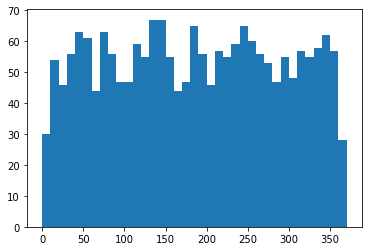

In [62]:
plt.bar(d.keys(), d.values(), width=10, align='edge')

# Test annotations (computed theta vs gt_theta)

In [18]:
n_test = 1000
for i in range(n_test):
    image, xc, yc, xt, yt, w, theta = train_dataset[i]
    theta_coord = np.arctan2(yt-yc, xt-xc) + math.radians(90)
    theta = normalize_theta(theta, False)
    theta_coord = normalize_theta(theta_coord, False)
    
    #Check annotations
    if abs(theta_coord - theta) > 1e-2:
        print('ID {} Initial Annot Error, annot {:.2f} calcs {:.2f}'.format(i, theta, theta_coord))
        
    tf = random.choice(list(tf_test.values()))
    #Apply transformation
    image_, xc_, yc_, xt_, yt_, w_, theta_ = tf((image, xc, yc, xt, yt, w, theta))
    #Verify that theta after transform is correct
    theta_aug = np.arctan2(yt_-yc_, xt_-xc_) + math.radians(90)
    theta_aug = normalize_theta(theta_aug, False)
    theta_ = normalize_theta(theta_, False)

    if abs(theta_aug - theta_) > 1e-2:
        print('ID {} Error, annot {:.4f} calcs {:.4f}'.format(i, theta_, theta_aug))

ID 71 Initial Annot Error, annot 1.78 calcs -0.00
ID 71 Error, annot 1.7793 calcs -0.0000
ID 382 Initial Annot Error, annot 0.93 calcs 0.01
ID 382 Error, annot 2.2082 calcs 3.1277
ID 431 Initial Annot Error, annot 2.95 calcs 0.66
ID 431 Error, annot 2.9549 calcs 0.6574
ID 452 Initial Annot Error, annot 2.27 calcs 0.44
ID 452 Error, annot -2.2666 calcs -0.4382
ID 600 Initial Annot Error, annot 0.89 calcs -0.00
ID 600 Error, annot 1.3801 calcs 0.4904


KeyboardInterrupt: 

In [16]:
math.degrees(-1.69), math.degrees(4.60)

(-96.82986737710912, 263.56058576017864)

# Data Loader test

In [4]:
train_transform = transforms.Compose([
                        custom_transforms.CropObjectAlignedArea(scale=2.),
                        custom_transforms.ResizeKeepRatio(min_size=600),
                        custom_transforms.RandomHorizontalFlip(p=0.5),
                        custom_transforms.RandomVerticalFlip(p=0.5),        
                        custom_transforms.RandomRotate(degrees=90, mode = 'edge'),
                        custom_transforms.RandomScale(scale=(0.8,1.2)),
                        custom_transforms.CropObjectAlignedArea(noise=0.05),
                        custom_transforms.Resize(cfg.MODEL.IMAGE_SIZE),
                        custom_transforms.ToTensor(),
                        custom_transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                               std =[0.229, 0.224, 0.225],
                                               input_size=cfg.MODEL.IMAGE_SIZE[0])
                        ])

In [5]:
valid_transform = transforms.Compose([
                        #custom_transforms.CropObjectAlignedArea(noise=0.),
                        #custom_transforms.Resize(cfg.MODEL.IMAGE_SIZE),
                        #custom_transforms.ResizeKeepRatio(min_size=256),
                        custom_transforms.ToTensor(),
                        custom_transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                               std =[0.229, 0.224, 0.225],
                                               input_size=cfg.MODEL.IMAGE_SIZE[0])
                        ])

In [6]:
train_dataset = eval('dataset.'+cfg.DATASET.CLASS)(cfg, True, train_transform)
valid_dataset = eval('dataset.'+cfg.DATASET.CLASS)(cfg, False, valid_transform)

loading annotations into memory...
Done (t=0.05s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [7]:
train_loader = torch.utils.data.DataLoader(train_dataset,
                                            batch_size=cfg.TRAIN.BS*len(cfg.GPUS),
                                            shuffle=True,
                                            num_workers=cfg.WORKERS,
                                            pin_memory=cfg.PIN_MEMORY
                                        )

In [8]:
valid_loader = torch.utils.data.DataLoader(valid_dataset,
                                            batch_size=cfg.TEST.BS*len(cfg.GPUS),
                                            shuffle=False,
                                            num_workers=cfg.WORKERS,
                                            pin_memory=cfg.PIN_MEMORY
                                        )

In [9]:
from utils.utils import unnormalize

In [10]:
%%time
for elem in train_loader:
    start = time.time()
    images, xc, yc, xt, yt, w, theta = elem
    print('proc time {:.3f}s'.format(time.time()-start))
    break

proc time 0.000s
CPU times: user 74.7 ms, sys: 190 ms, total: 265 ms
Wall time: 26.1 s


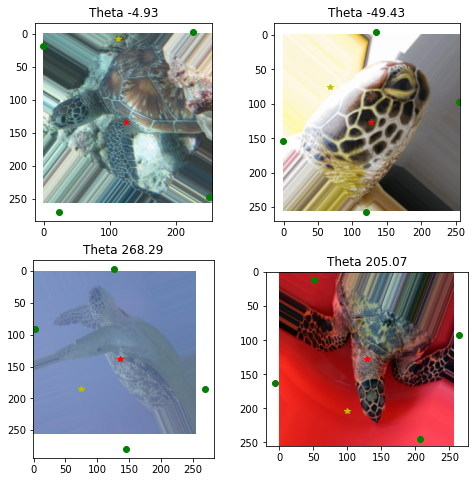

In [26]:
save_batch_images(images, torch.stack([xc, yc, xt, yt, w], dim=1)*256, theta, 'test', max_cols=2)

In [15]:
images_un = unnormalize(images)

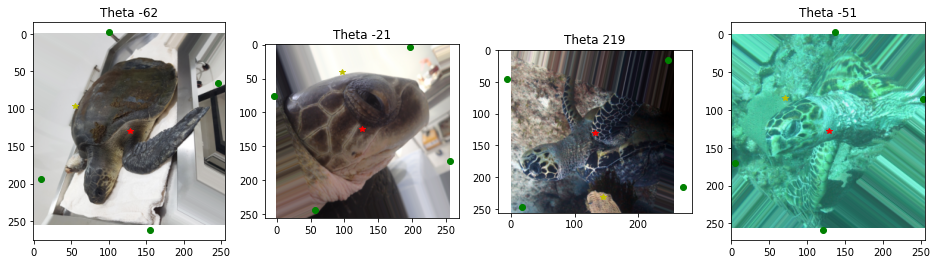

In [19]:
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(4*4, 1*4))
for c in range(4):
    plot_image_coordinates(ax[c], 
                           images_un[c].numpy().transpose((1,2,0)), 
                           xc[c].numpy()*cfg.MODEL.IMAGE_SIZE[0], 
                           yc[c].numpy()*cfg.MODEL.IMAGE_SIZE[0], 
                           xt[c].numpy()*cfg.MODEL.IMAGE_SIZE[0], 
                           yt[c].numpy()*cfg.MODEL.IMAGE_SIZE[0], 
                           w[c].numpy()*cfg.MODEL.IMAGE_SIZE[0], 
                           theta[c].numpy())
    ax[c].set_title('Theta {:.0f}'.format(math.degrees(theta[c])))

In [20]:
xc, yc, xt, yt, w, theta

(tensor([0.5000, 0.4922, 0.5156, 0.5039]),
 tensor([0.5078, 0.4844, 0.5117, 0.5000]),
 tensor([0.2148, 0.3750, 0.5625, 0.2773]),
 tensor([0.3750, 0.1562, 0.9023, 0.3281]),
 tensor([0.4221, 0.4150, 0.4980, 0.4241]),
 tensor([-1.0901, -0.3743,  3.8298, -0.8926]))

# Models

TODO

1. Define which layers to retrain: https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html
2. 

In [19]:
from torchvision import models

In [26]:
core_name = 'resnet50'
model = eval('models.'+core_name)(pretrained=False, progress=True)

In [27]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

# Theta angle to class

In [9]:
te = [train_dataset[i][-1] for i in range(20)]
te

[-3.0788010570314217,
 2.417757188248967,
 3.1319960192198533,
 -7.382437563116309,
 -5.6487426351354575,
 -12.566370614359172,
 -7.853981633974483,
 -1.5707963267948966,
 3.9980958116396437,
 -1.6167004524688835,
 4.600939366349698,
 -1.5707963267948966,
 -1.5707963267948966,
 -1.5707963267948966,
 -7.505559264891268,
 5.319119883053652,
 4.917784369574457,
 8.626944987629667,
 -1.622347124460716,
 -2.335789159505807]

In [12]:
for i, t in enumerate(te):
    print("{:.3f}\t {:.3f}\t {:.3f}\t {:.3f}".format(t, math.cos(t), ten[i], math.cos(ten[i])))

-3.079	 -0.998	 -3.079	 -0.998
2.418	 -0.749	 2.418	 -0.749
3.132	 -1.000	 3.132	 -1.000
-7.382	 0.454	 -1.099	 0.454
-5.649	 0.805	 0.634	 0.805
-12.566	 1.000	 0.000	 1.000
-7.854	 0.000	 -1.571	 0.000
-1.571	 0.000	 -1.571	 0.000
3.998	 -0.655	 -2.285	 -0.655
-1.617	 -0.046	 -1.617	 -0.046
4.601	 -0.111	 -1.682	 -0.111
-1.571	 0.000	 -1.571	 0.000
-1.571	 0.000	 -1.571	 0.000
-1.571	 0.000	 -1.571	 0.000
-7.506	 0.341	 -1.222	 0.341
5.319	 0.570	 -0.964	 0.570
4.918	 0.204	 -1.365	 0.204
8.627	 -0.698	 2.344	 -0.698
-1.622	 -0.052	 -1.622	 -0.052
-2.336	 -0.693	 -2.336	 -0.693


In [14]:
np.arccos(np.cos(te))

array([3.07880106, 2.41775719, 3.13199602, 1.09925226, 0.63444267,
       0.        , 1.57079633, 1.57079633, 2.2850895 , 1.61670045,
       1.68224594, 1.57079633, 1.57079633, 1.57079633, 1.22237396,
       0.96406542, 1.36540094, 2.34375968, 1.62234712, 2.33578916])